In [113]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [114]:
#한글 깨짐 방지
from matplotlib import rc, font_manager
font_path='../data/fonts/malgun.ttf'
font_name=font_manager.FontProperties(fname=font_path).get_name()
rc('font',family=font_name)
#마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus']=False

In [136]:
# mackerel=pd.read_csv('../data/merge/mackerel_price.csv',encoding='cp949')
mackerel=pd.read_csv('../data/merge/mackerel_price_trade.csv')

# '%Y-%m' 형식으로 변환
mackerel['date'] = pd.to_datetime(mackerel['date'], format='%Y-%m-%d')

# 'date' 열을 인덱스로 설정
mackerel.set_index('date', inplace=True)
mackerel=mackerel[['생산량','수입','수출','가격 (원)']]
# mackerel=mackerel[[,'생산량','가격 (원)']]
mackerel.info()
mackerel

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 108 entries, 2014-01-01 to 2022-12-01
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   생산량     108 non-null    int64
 1   수입      108 non-null    int64
 2   가격 (원)  108 non-null    int64
dtypes: int64(3)
memory usage: 3.4 KB


,생산량,수입,가격 (원)
date,,,
2014-01-01,5663,3476,3422
2014-02-01,3565,1101,4073
2014-03-01,2620,2011,3891
2014-04-01,1525,2454,4259
2014-05-01,412,1995,3512
...,...,...,...
2022-08-01,3900,2056,3543
2022-09-01,5494,2194,2733
2022-10-01,5339,679,2875


In [116]:
seq_length=3 # 3~7사이 값 설정
train_size = int(len(mackerel)*0.9)
train_set=mackerel[0:train_size]
test_set=mackerel[train_size-seq_length:]
print(train_set.shape,test_set.shape)


(97, 3) (14, 3)


In [117]:
train_set.head()

,생산량,참조기,가격 (원)
date,,,
2014-01-01,5663,3,3422
2014-02-01,3565,1,4073
2014-03-01,2620,1,3891
2014-04-01,1525,6,4259
2014-05-01,412,3,3512


In [118]:
#input scale
scaler_x=MinMaxScaler()
scaler_x.fit(train_set.iloc[:, :-1])

train_set.iloc[:, :-1]=scaler_x.transform(train_set.iloc[:, :-1])
test_set.iloc[:, :-1]=scaler_x.transform(test_set.iloc[:, :-1])

# output scale
scaler_y=MinMaxScaler()
scaler_y.fit(train_set.iloc[:,[-1]])
train_set.iloc[:, -1]=scaler_y.transform(train_set.iloc[:,[-1]])
test_set.iloc[:, -1]=scaler_y.transform(test_set.iloc[:,[-1]])

In [119]:
test_set[:]

,생산량,참조기,가격 (원)
date,,,
2021-11-01,0.493993,0.876560,0.463318
2021-12-01,0.812506,0.428571,0.467884
2022-01-01,0.408929,0.023578,0.511111
2022-02-01,0.065691,0.004161,0.592694
2022-03-01,0.101518,0.005548,0.546423
2022-04-01,0.004531,0.000000,0.835921
2022-05-01,0.006995,0.006935,1.125419
2022-06-01,0.017731,0.004161,0.833486
2022-07-01,0.076184,0.006935,0.619787


In [120]:
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더
import numpy as np

In [121]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(125)
if torch.cuda.is_available() :
    torch.cuda.manual_seed_all(125)

In [122]:
def build_dataset(time_series, seq_length):
    dataX=[]
    dataY=[]
    for i in range(0, len(time_series)-seq_length):
        x_=time_series[i:i+seq_length, :]
        y_=time_series[i+seq_length,[2]]
        dataX.append(x_)
        dataY.append(y_)
    return np.array(dataX), np.array(dataY)

In [123]:
trainX, trainY=build_dataset(np.array(train_set), seq_length)
testX, testY=build_dataset(np.array(test_set),seq_length)

print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(94, 3, 3) (94, 1)
(11, 3, 3) (11, 1)


In [124]:
trainX_tensor=torch.FloatTensor(trainX)
trainY_tensor=torch.FloatTensor(trainY)
testX_tensor=torch.FloatTensor(testX)
testY_tensor=torch.FloatTensor(testY)

print(trainX_tensor.size(), trainY_tensor.size())
print(testX_tensor.size(), testY_tensor.size())

torch.Size([94, 3, 3]) torch.Size([94, 1])
torch.Size([11, 3, 3]) torch.Size([11, 1])


In [125]:
train_dataset=TensorDataset(trainX_tensor, trainY_tensor)
train_loader=DataLoader(train_dataset, shuffle=True,
                        drop_last=True)

In [126]:
# 수정 필요

data_dim=3
hidden_dim=6
output_dim=1
learning_late=0.01
epochs=5000

In [127]:
class Net(nn.Module):
  def __init__(self, input_dim, hidden_dim, seq_length, output_dim, layers):
    super(Net, self).__init__()
    self.hidden_dim=hidden_dim
    self.seq_length=seq_length
    self.output_dim=output_dim
    self.layers=layers

    self.lstm=nn.LSTM(input_dim, 
                      hidden_dim, 
                      num_layers=layers,
                      batch_first=True)
    self.fc=nn.Linear(hidden_dim, output_dim, bias=True)

  def reset_hidden_state(self):
    self.hidden=(
      torch.zeros(self.layers, self.seq_length, self.hidden_dim),
      torch.zeros(self.layers, self.seq_length, self.hidden_dim)
    )
  def forward(self, x):
    x, _status=self.lstm(x)
    x=self.fc(x[:, -1])
    return x

In [128]:
def train_model(model, train_df, epochs=None, lr=None, verbos=10, patience=10):
  criterion=nn.MSELoss().to(device)
  optimizer=optim.Adam(model.parameters())
  n_epochs=epochs

  train_hist=np.zeros(n_epochs)
  for epoch in range(n_epochs):
    avg_cost=0
    total_batch=len(train_df)

    for batch_idxm, sample in enumerate(train_df):
      x_train, y_train=sample
      model.reset_hidden_state()
      output=model(x_train)
      loss=criterion(output, y_train)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      avg_cost+=loss/total_batch
    
    train_hist[epoch]=avg_cost

    if epoch % verbos==0:
      print('Epoch:{}, train_loss:{}'.format(epoch, avg_cost.item()))

    if(epoch % patience==0) & (epoch!=0):
      if train_hist[epoch-patience] < train_hist[epoch]:
        print("Early Stopping")
        break
  return model.eval(), train_hist

# best loss / model 추가

In [129]:
net=Net(data_dim, hidden_dim, seq_length, output_dim, 1)
model, train_hist=train_model(net, train_loader, epochs=epochs,
                              lr=learning_late, verbos=20, patience=100)

Epoch:0, train_loss:0.039529960602521896
Epoch:20, train_loss:0.015331221744418144
Epoch:40, train_loss:0.013925964944064617
Epoch:60, train_loss:0.012704364955425262
Epoch:80, train_loss:0.011996174231171608
Epoch:100, train_loss:0.011347663588821888
Epoch:120, train_loss:0.011465962044894695
Epoch:140, train_loss:0.010900577530264854
Epoch:160, train_loss:0.010590953752398491
Epoch:180, train_loss:0.01057975459843874
Epoch:200, train_loss:0.010295034386217594
Epoch:220, train_loss:0.010199250653386116
Epoch:240, train_loss:0.009891906753182411
Epoch:260, train_loss:0.009948010556399822
Epoch:280, train_loss:0.009741249494254589
Epoch:300, train_loss:0.00960052665323019
Epoch:320, train_loss:0.009274526499211788
Epoch:340, train_loss:0.009162332862615585
Epoch:360, train_loss:0.00894103106111288
Epoch:380, train_loss:0.008906117640435696
Epoch:400, train_loss:0.008548657409846783
Epoch:420, train_loss:0.008315159007906914
Epoch:440, train_loss:0.008287875913083553
Epoch:460, train_los

In [130]:
path="../model/price_수입.pth"
torch.save(model.state_dict(), path)

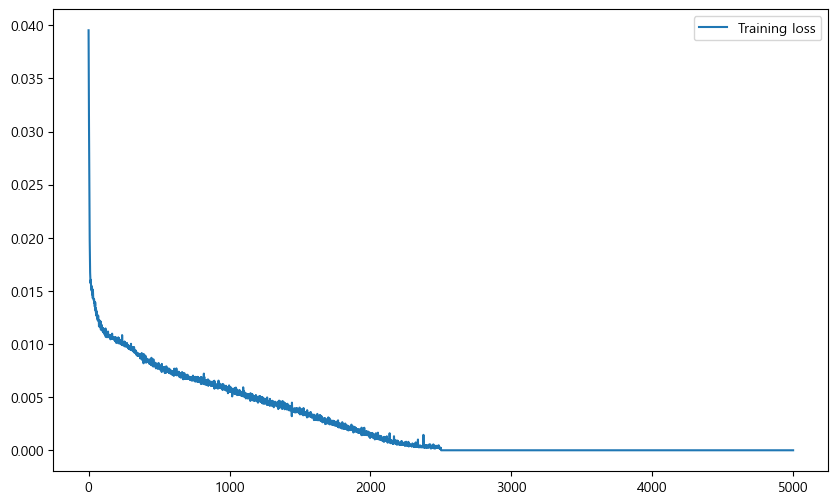

In [131]:
fig=plt.figure(figsize=(10, 6))
plt.plot(train_hist, label='Training loss')
plt.legend()
plt.show()

In [132]:
with torch.no_grad():
    pred=[]
    for pr in range(len(testX_tensor)):
        model.reset_hidden_state()
        predicted=model(torch.unsqueeze(testX_tensor[pr],0))
        predicted=torch.flatten(predicted).item()
        pred.append(predicted)

    pred_inverse=scaler_y.inverse_transform(np.array(pred).reshape(-1, 1))
    testY_inverse=scaler_y.inverse_transform(testY_tensor)

def MAE(true, pred):
    return np.mean(np.abs(true-pred))


print('MAe SCORE:', MAE(pred_inverse, testY_inverse))

MAe SCORE: 867.7543296055359


In [133]:
test_set.index[seq_length:]

DatetimeIndex(['2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01',
               '2022-06-01', '2022-07-01', '2022-08-01', '2022-09-01',
               '2022-10-01', '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', name='date', freq=None)

In [134]:
date=['2023-02', '2023-03', '2023-04',
               '2023-05', '2023-06', '2023-07', '2023-08',
               '2023-09', '2023-10', '2023-11', '2023-12']

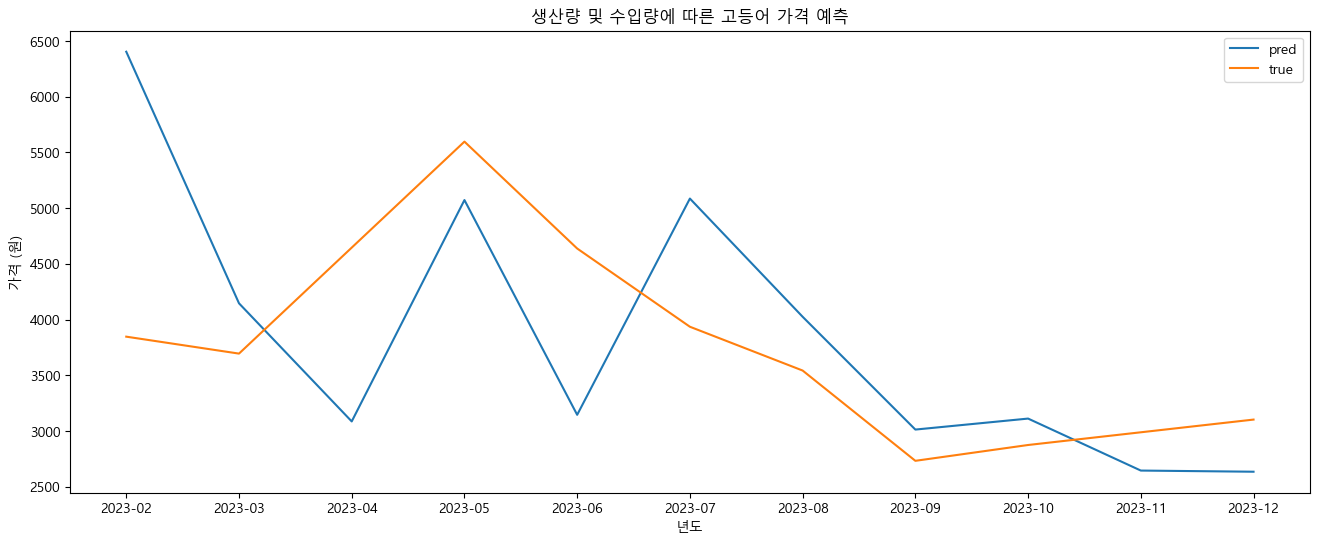

In [135]:
fig=plt.figure(figsize=(16,6))
plt.title('생산량 및 수입량에 따른 고등어 가격 예측')
plt.plot(np.arange(len(pred_inverse)), pred_inverse, label='pred')
plt.plot(np.arange(len(testY_inverse)), testY_inverse, label='true')
plt.xlabel('년도')
plt.ylabel('가격 (원)')

plt.xticks(np.arange(len(pred_inverse)),date)
plt.legend()
plt.show()